# Finetuning moondream

This notebook is a modified copy of the original notebook here: https://github.com/vikhyat/moondream/blob/main/notebooks/Finetuning.ipynb

# Install Packages

In [ ]:
!pip install torch transformers timm einops datasets bitsandbytes accelerate roboflow supervision -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
# Run if you are using flash attention. Make sure to restart your runtime
!pip install flash-attn --no-build-isolation -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


# Dataset Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

# Create directory if it doesn't exist
os.makedirs('/content/arch_data', exist_ok=True)

# Unzip the file
with zipfile.ZipFile('/content/drive/MyDrive/arch_data.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/arch_data')

In [ ]:
from torch.utils.data import Dataset
from PIL import Image
import json
import os
import random

class ArchitectureDataset(Dataset):
    def __init__(self, dataset_path, json_path, split, samples_per_style=None):
        self.dataset_path = dataset_path
        self.split = split

        # Original comprehensive question
        self.question = ("Describe this building's architectural style in detail. What are its key features? "
                        "What period and region is this style associated with? What materials are predominantly "
                        "used in this building? Describe any notable decorative elements, patterns, or ornaments. "
                        "Describe the overall structure, including the shape, height, and any distinctive "
                        "architectural elements like towers, domes, or facades. If the building has a name, "
                        "please state it in the beginning.")

        # Load and parse JSON
        with open(json_path, 'r', encoding='utf-8') as f:
            self.annotations = json.load(f)

        # Group images by style
        self.style_groups = {}
        for item in self.annotations:
            # Clean up the description by removing <|endoftext|>
            item['description'] = item['description'].replace("<|endoftext|>", "").strip()

            style = item['style']
            if style not in self.style_groups:
                self.style_groups[style] = []
            self.style_groups[style].append(item)

        # Create train/val/test split for each style
        self.data = []
        for style, items in self.style_groups.items():
            # Shuffle items for this style
            shuffled_items = random.sample(items, len(items))

            if split == "train":
                selected_items = shuffled_items[:samples_per_style]
            elif split == "val":
                val_start = samples_per_style
                val_end = val_start + SAMPLES_PER_STYLE["val"]
                selected_items = shuffled_items[val_start:val_end]
            else:  # test
                test_start = samples_per_style + SAMPLES_PER_STYLE["val"]
                test_end = test_start + SAMPLES_PER_STYLE["test"]
                selected_items = shuffled_items[test_start:test_end]

            self.data.extend(selected_items)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]

        # Fix path separators and handle the double arch_data issue
        image_path = item['image_path'].replace('\\', '/')
        if 'arch_data' in image_path:
            image_path = image_path[image_path.find('arch_data')+len('arch_data/'):]

        # Combine with dataset path
        full_path = os.path.join(self.dataset_path, 'arch_data', image_path)

        image = Image.open(full_path).convert('RGB')

        # Use the cleaned description as the answer
        answer = item['description']

        return {
            "image": image,
            "image_path": full_path,  # Include the full path
            "original_path": item['image_path'],  # Include the original path from JSON
            "qa": [{"question": self.question, "answer": answer}]
        }



# Define the number of samples per style for each split
SAMPLES_PER_STYLE = {
    "train": 35,
    "val": 0,
    "test": 10
}

datasets = {
    "train": ArchitectureDataset("/content/drive/MyDrive/arch_data", "/content/drive/MyDrive/edited_descriptions.json", "train", SAMPLES_PER_STYLE["train"]),
    "val": ArchitectureDataset("/content/drive/MyDrive/arch_data", "/content/drive/MyDrive/edited_descriptions.json", "val", SAMPLES_PER_STYLE["val"]),
    "test": ArchitectureDataset("/content/drive/MyDrive/arch_data", "/content/drive/MyDrive/edited_descriptions.json", "test", SAMPLES_PER_STYLE["test"])
}

print(len(datasets["train"]))
print(len(datasets["val"]))
print(len(datasets["test"]))

print(datasets["train"][0]["original_path"])

560
0
160
arch_data\architectural-styles-dataset\Chicago school architecture\493_450px-Sandberg-Schoenfeld_Buildings.jpg


Now let's take a look at a sample image from the training set and compare the ground-truth answers
with moondream predictions.

In [ ]:
# Initialize moondream. Change DEVICE to 'mps' if you're on an M1 Mac, or 'cpu' if you don't have a
# GPU. Note that fine-tuning on CPU will be very slow.

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

DEVICE = "cuda"
FLASHATTENTION = "flash_attention_2" # "flash_attention_2" if A100, RTX 3090, RTX 4090, H100, None if CPU
DTYPE = torch.float32 if DEVICE == "cpu" else torch.float16 # CPU doesn't support float16
MD_REVISION = "2024-07-23"

tokenizer = AutoTokenizer.from_pretrained("vikhyatk/moondream2", revision=MD_REVISION)
moondream = AutoModelForCausalLM.from_pretrained(
    "vikhyatk/moondream2", revision=MD_REVISION, trust_remote_code=True,
    attn_implementation=FLASHATTENTION,
    torch_dtype=DTYPE, device_map={"": DEVICE}
)

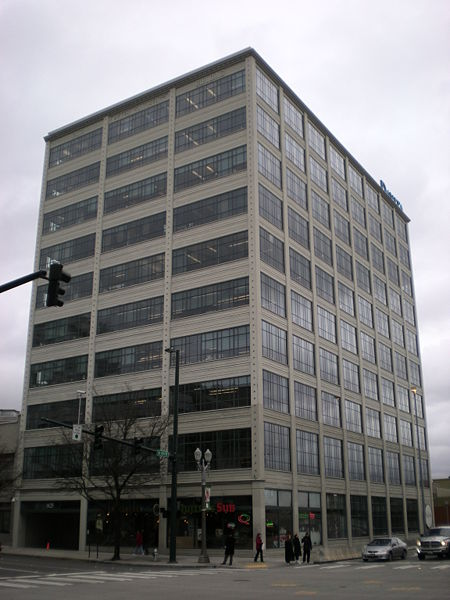

Question: Describe this building's architectural style in detail. What are its key features? What period and region is this style associated with? What materials are predominantly used in this building? Describe any notable decorative elements, patterns, or ornaments. Describe the overall structure, including the shape, height, and any distinctive architectural elements like towers, domes, or facades. If the building has a name, please state it in the beginning.
Ground Truth: This building exhibits characteristics of modernist architecture, which became prominent in the mid-20th century. Key features include its simple geometric shapes, large glass windows, and minimalistic design. The predominant material used appears to be concrete or a similar composite, common in post-war construction due to its durability and cost-effectiveness.

The facade is devoid of ornate decorations, emphasizing function over form, which is a hallmark of modernism. Notable elements include the uniformity of 

In [ ]:
from IPython.display import display

sample = datasets['train'][0]
display(sample['image'])

for qa in sample['qa']:
    print('Question:', qa['question'])
    print('Ground Truth:', qa['answer'])
    print('Moondream:', moondream.answer_question(
        moondream.encode_image(sample['image']),
        qa['question'],
        tokenizer=tokenizer,
    ))

# Fine-tuning
Let's start setting up hyperparameters for finetuning.

In [ ]:
# Number of times to repeat the training dataset. Increasing this may cause the model to overfit or
# lose generalization due to catastrophic forgetting. Decreasing it may cause the model to underfit.
EPOCHS = 5

# Number of samples to process in each batch. Set this to the highest value that doesn't cause an
# out-of-memory error. Decrease it if you're running out of memory. Batch size 8 currently uses around
# 15 GB of GPU memory during fine-tuning.
BATCH_SIZE = 24

# Number of batches to process before updating the model. You can use this to simulate a higher batch
# size than your GPU can handle. Set this to 1 to disable gradient accumulation.
GRAD_ACCUM_STEPS = 1

# Learning rate for the Adam optimizer. Needs to be tuned on a case-by-case basis. As a general rule
# of thumb, increase it by 1.4 times each time you double the effective batch size.
#
# Source: https://www.cs.princeton.edu/~smalladi/blog/2024/01/22/SDEs-ScalingRules/
#
# Note that we linearly warm the learning rate up from 0.1 * LR to LR over the first 10% of the
# training run, and then decay it back to 0.1 * LR over the last 90% of the training run using a
# cosine schedule.
LR = 3e-5

# Whether to use Weights and Biases for logging training metrics.
USE_WANDB = True


In [ ]:
!pip install wandb

In [ ]:
!nvidia-smi

Tue Nov 26 23:43:35 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   69C    P0              32W /  72W |   8065MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
torch.cuda.empty_cache()

This next block will start the training process.

In [ ]:
from torch.utils.data import DataLoader
from bitsandbytes.optim import Adam8bit
import math
from einops import rearrange
from tqdm import tqdm

ANSWER_EOS = "<|endoftext|>"

# Number of tokens used to represent each image.
IMG_TOKENS = 729

def collate_fn(batch):
    images = [sample['image'] for sample in batch]
    images = [moondream.vision_encoder.preprocess(image) for image in images]

    labels_acc = []
    tokens_acc = []

    for sample in batch:
        toks = [tokenizer.bos_token_id]
        labs = [-100] * (IMG_TOKENS + 1)

        for qa in sample['qa']:
            q_t = tokenizer(
                f"\n\nQuestion: {qa['question']}\n\nAnswer:",
                add_special_tokens=False
            ).input_ids
            toks.extend(q_t)
            labs.extend([-100] * len(q_t))

            a_t = tokenizer(
                f" {qa['answer']}{ANSWER_EOS}",
                add_special_tokens=False
            ).input_ids
            toks.extend(a_t)
            labs.extend(a_t)

        tokens_acc.append(toks)
        labels_acc.append(labs)

    max_len = -1
    for labels in labels_acc:
        max_len = max(max_len, len(labels))

    attn_mask_acc = []

    for i in range(len(batch)):
        len_i = len(labels_acc[i])
        pad_i = max_len - len_i

        labels_acc[i].extend([-100] * pad_i)
        tokens_acc[i].extend([tokenizer.eos_token_id] * pad_i)
        attn_mask_acc.append([1] * len_i + [0] * pad_i)

    return (
        images,
        torch.stack([torch.tensor(t, dtype=torch.long) for t in tokens_acc]),
        torch.stack([torch.tensor(l, dtype=torch.long) for l in labels_acc]),
        torch.stack([torch.tensor(a, dtype=torch.bool) for a in attn_mask_acc]),
    )

def compute_loss(batch):
    images, tokens, labels, attn_mask = batch

    tokens = tokens.to(DEVICE)
    labels = labels.to(DEVICE)
    attn_mask = attn_mask.to(DEVICE)

    with torch.no_grad():
        img_embs = moondream.vision_encoder(images)

    tok_embs = moondream.text_model.get_input_embeddings()(tokens)
    inputs_embeds = torch.cat((tok_embs[:, 0:1, :], img_embs, tok_embs[:, 1:, :]), dim=1)

    outputs = moondream.text_model(
        inputs_embeds=inputs_embeds,
        labels=labels,
        attention_mask=attn_mask,
    )

    return outputs.loss

def lr_schedule(step, max_steps):
    x = step / max_steps
    if x < 0.1:
        return 0.1 * LR + 0.9 * LR * x / 0.1
    else:
        return 0.1 * LR + 0.9 * LR * (1 + math.cos(math.pi * (x - 0.1))) / 2

dataloaders = {
    "train": DataLoader(
        datasets["train"],
        batch_size=BATCH_SIZE,
        shuffle=True,
        collate_fn=collate_fn,
    ),
    "val": DataLoader(
        datasets["val"],
        batch_size=BATCH_SIZE,
        shuffle=False,
        collate_fn=collate_fn,
    )
}

def validate(model, dataloader):
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Validating"):
            loss = compute_loss(batch)
            total_val_loss += loss.item()
    avg_val_loss = total_val_loss / len(dataloader)
    model.train()
    return avg_val_loss

moondream.text_model.train()
moondream.text_model.transformer.gradient_checkpointing_enable()

total_steps = EPOCHS * len(dataloaders["train"]) // GRAD_ACCUM_STEPS
optimizer = Adam8bit(
    [
        {"params": moondream.text_model.parameters()},
    ],
    lr=LR * 0.1,
    betas=(0.9, 0.95),
    eps=1e-6
)

if USE_WANDB:
    import wandb
    wandb.init(
        project="moondream-ft",
        config={
            "EPOCHS": EPOCHS,
            "BATCH_SIZE": BATCH_SIZE,
            "GRAD_ACCUM_STEPS": GRAD_ACCUM_STEPS,
            "LR": LR,
        }
    )

i = 0
for epoch in range(EPOCHS):
    for batch in tqdm(dataloaders["train"], desc=f"Epoch {epoch + 1}/{EPOCHS}"):
        i += 1

        loss = compute_loss(batch)
        loss.backward()

        if i % GRAD_ACCUM_STEPS == 0:
            optimizer.step()
            optimizer.zero_grad()

            lr = lr_schedule(i / GRAD_ACCUM_STEPS, total_steps)
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr

        if USE_WANDB:
            wandb.log({
                "loss/train": loss.item(),
                "lr": optimizer.param_groups[0]['lr']
            })

if USE_WANDB:
    wandb.finish()

Epoch 5/5: 100%|██████████| 24/24 [01:23<00:00,  3.48s/it]


loss/train,█▇▇▆▆▆▅▅▄▄▄▄▄▄▄▃▄▃▃▃▂▃▃▃▃▂▂▁▂▂▂▂▂▂▁▁▁▁▁▁
lr,▃▃▄▆██████▇▇▇▇▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▂▂▂▂▂▂▁▁
loss/train,0.64502
lr,0.0


In [ ]:
moondream.save_pretrained("/content/drive/MyDrive/moondream2-2307-5epochs-35per")

In [ ]:
import shutil
shutil.make_archive("coincounter_zip", 'zip', "checkpoints/moondream2-0402-carcounter")

'/content/coincounter_zip.zip'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/coincounter_zip.zip /content/drive/MyDrive/carcounter.zip

# Evaluation
Now that training has completed, let's inspect a few samples and calculate accuracy.

In [ ]:
from IPython.display import display
import json
import numpy as np
from PIL import Image
import os

def extract_style_from_path(path):
    # Normalize path separators
    path = path.replace('\\', '/')

    # Split path and look for the style folder
    path_parts = path.split('/')
    try:
        # Find the part that contains both "architecture" and isn't just the dataset folder
        style_folder = next(part for part in path_parts
                          if 'architecture' in part.lower()
                          and 'dataset' not in part.lower())

        # Clean up the style name
        style_name = style_folder.replace('architecture', '').strip()
        # Remove any trailing backslashes or slashes
        style_name = style_name.rstrip('\\/').strip()
        return style_name
    except StopIteration:
        # If no style folder is found, try to get it from the parent folder name
        try:
            # Find index of 'dataset' and take the next folder name
            dataset_idx = path_parts.index('architectural-styles-dataset')
            if dataset_idx + 1 < len(path_parts):
                style_folder = path_parts[dataset_idx + 1]
                return style_folder.replace('architecture', '').strip()
        except ValueError:
            pass
        return "Unknown Style"

moondream.eval()

correct = 0
total_samples = len(datasets['test'])
incorrect_samples = []

# Simple question focusing only on style
style_question = "What architectural style is shown in this image?"

print("Starting evaluation...\n")

for i, sample in enumerate(datasets['test']):
    print(f"\nTesting sample {i+1}/{total_samples}")

    # Extract style from the original path
    ground_truth_style = extract_style_from_path(sample['original_path'])

    # Get model's answer
    md_answer = moondream.answer_question(
        moondream.encode_image(sample['image']),
        style_question,
        tokenizer=tokenizer,
    )

    # Check if the style appears in the model's answer (case insensitive)
    # Clean up both strings for comparison
    gt_style_clean = ground_truth_style.lower().strip()
    md_answer_clean = md_answer.lower().strip()

    if gt_style_clean in md_answer_clean or any(word in md_answer_clean for word in gt_style_clean.split()):
        correct += 1
        print("✓ Correct!")
    else:
        incorrect_samples.append({
            'image': sample['image'],
            'ground_truth': ground_truth_style,
            'prediction': md_answer,
            'image_path': sample['original_path']
        })
        print("✗ Incorrect")

    # Display current sample results
    display(sample['image'])
    print('Image Path:', sample['original_path'])
    print('Ground Truth Style:', ground_truth_style)
    print('Moondream Answer:', md_answer)
    print('-' * 80)

accuracy = (correct / total_samples) * 100

print("\n=== Final Results ===")
print(f"Total Samples: {total_samples}")
print(f"Correct Predictions: {correct}")
print(f"Accuracy: {accuracy:.2f}%")

# Display some incorrect examples
print("\n=== Some Incorrect Predictions ===")
for i, incorrect in enumerate(incorrect_samples[:3]):  # Show first 3 incorrect predictions
    print(f"\nIncorrect Example {i+1}:")
    display(incorrect['image'])
    print('Image Path:', incorrect['image_path'])
    print('Ground Truth Style:', incorrect['ground_truth'])
    print('Model Prediction:', incorrect['prediction'])
    print('-' * 80)